In [1]:
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
import os
from PIL import Image

data_dir = 'data'

target_size = (32, 32)

for dir_name in os.listdir(data_dir):
    dir_path = os.path.join(data_dir, dir_name)
    if os.path.isdir(dir_path):
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            with Image.open(img_path) as img:
                img_resized = img.resize(target_size)
                img_resized.save(img_path) 

In [3]:
import torch.nn as nn

class DiscriminatorNet(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding="same")  # 3 inputy, 32 outputow, 4x4 kernel
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding="same")
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 4, stride=2, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.lrelu = nn.LeakyReLU(negative_slope=0.01)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        x = self.lrelu(self.bn3(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [4]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 64 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 256, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 3, 5, padding="same")
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.tanh = nn.Tanh()
        
        

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 64, 4, 4)
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.conv4(x)
        x = self.tanh(x)

        return x

In [29]:
def noise(size, n=64): 
    return torch.randn(size, n) # size x 64

In [8]:
generator = GeneratorNet()
generator.to(device)
pass # avoid print

In [9]:
import matplotlib.pyplot as plt

def show_generated_image(img):
    img = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

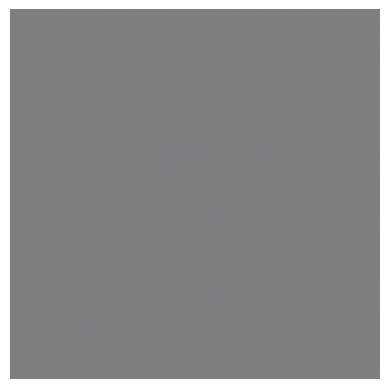

In [10]:
generator.eval()

with torch.no_grad():
    img = generator(noise(1).to(device))
    show_generated_image(img)

generator.train()
pass  # avoid print

In [21]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder('data/real_cakes', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)

In [14]:
dataiter = iter(dataloader)

In [17]:
def show_images(images):
    fig = plt.figure(figsize=(16, 8))
    for i, img in enumerate(images):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2
        img = (img * 255).astype('uint8')
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(img)
    plt.show()

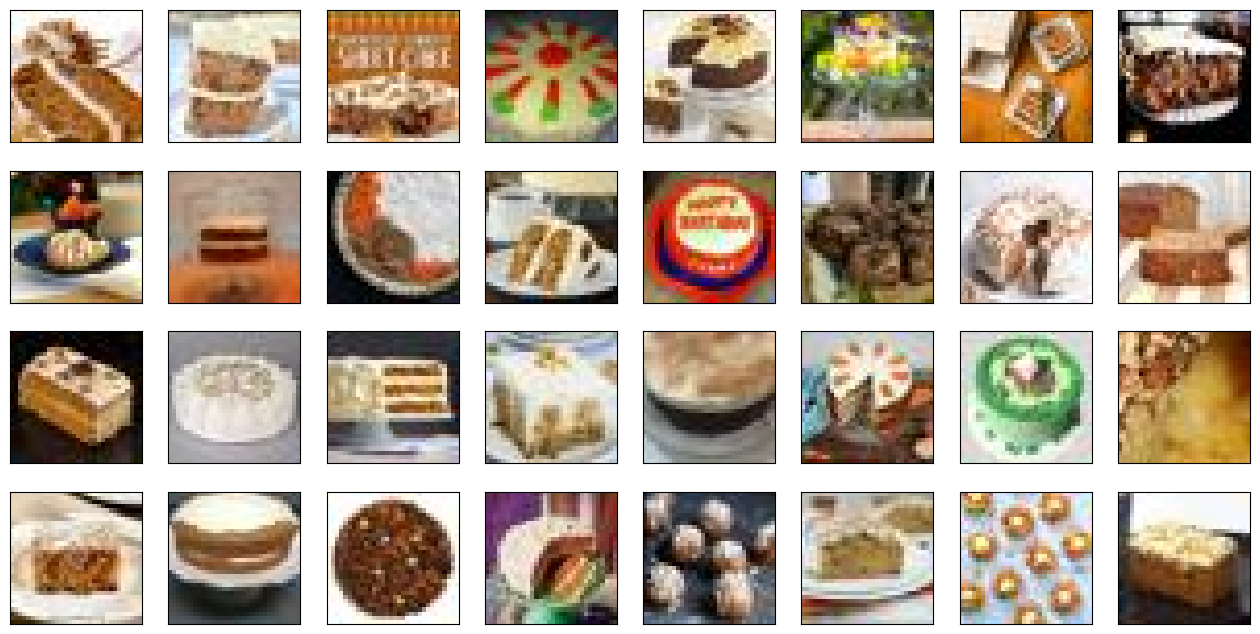

In [22]:
images, _ = next(dataiter)
show_images(images)

In [26]:
class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 3)
        
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [87]:
test_net = TestNet()
test_net.to(device)
pass # avoid print

In [32]:
def my_test_loss(output):
    return (torch.mean(output) - 42) ** 2

In [88]:
import torch.optim as optim

test_batch = noise(32, 3).to(device)
optimizer = optim.SGD(test_net.fc1.parameters(), lr=0.01)

for i in range(1000):
    output = test_net(test_batch)
    
    loss = my_test_loss(output)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    if i % 10 == 9:
        print(f"{i + 1}, Loss: {loss.item():.4f}")

10, Loss: 1699.8179
20, Loss: 1641.1125
30, Loss: 1584.4344
40, Loss: 1529.7139
50, Loss: 1476.8834
60, Loss: 1425.8771
70, Loss: 1376.6327
80, Loss: 1329.0890
90, Loss: 1283.1871
100, Loss: 1238.8704
110, Loss: 1196.0845
120, Loss: 1154.7760
130, Loss: 1114.8944
140, Loss: 1076.3900
150, Loss: 1039.2156
160, Loss: 1003.3248
170, Loss: 968.6736
180, Loss: 935.2192
190, Loss: 902.9202
200, Loss: 871.7366
210, Loss: 841.6300
220, Loss: 812.5632
230, Loss: 784.5004
240, Loss: 757.4066
250, Loss: 731.2485
260, Loss: 705.9939
270, Loss: 681.6115
280, Loss: 658.0711
290, Loss: 635.3438
300, Loss: 613.4014
310, Loss: 592.2167
320, Loss: 571.7637
330, Loss: 552.0172
340, Loss: 532.9525
350, Loss: 514.5463
360, Loss: 496.7757
370, Loss: 479.6189
380, Loss: 463.0546
390, Loss: 447.0624
400, Loss: 431.6226
410, Loss: 416.7159
420, Loss: 402.3241
430, Loss: 388.4294
440, Loss: 375.0144
450, Loss: 362.0628
460, Loss: 349.5585
470, Loss: 337.4860
480, Loss: 325.8305
490, Loss: 314.5775
500, Loss: 30

In [ ]:
# koniec 6. Zacznijmy od łatwiejszej fazy - uczenia dyskryminatora. [⌨️]